In [42]:
import pandas as pd
import numpy as np
import datetime as dt
#from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from lifelines import CoxPHFitter

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import FitFailedWarning
import sksurv.util
import warnings
from lifelines.utils import k_fold_cross_validation

from sklearn.linear_model import LassoCV

from sksurv.preprocessing import OneHotEncoder


df=pd.read_csv("../1_data/private/preprocessed_data.csv")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


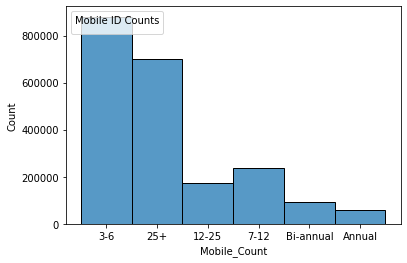

In [43]:
# make age categorical - high school age
df['high_school_age']=np.where(df['Visit_Age']<=20, 1, 0)

#categorize counts variable which indicates how often the collection site ID occurs in data set?
df.loc[(df['Counts']==1), 'Mobile_Count'] = 'Annual'
df.loc[(df['Counts']==2), 'Mobile_Count'] = 'Bi-annual'
df.loc[((df['Counts']>2) & (df['Counts']<=6)), 'Mobile_Count']='3-6'
df.loc[((df['Counts']>6) & (df['Counts']<=12)), 'Mobile_Count']='7-12'
df.loc[((df['Counts']>12) & (df['Counts']<=25)), 'Mobile_Count']='12-25'
df.loc[(df['Counts']>25), 'Mobile_Count']= '25+'

plt.figure()
#plt.axis([0, 50, 0, 5000])
h=sns.histplot(data=df, x="Mobile_Count", binwidth=1, multiple="stack")
plt.legend(title='Mobile ID Counts', loc='upper left')
plt.show(h)

In [50]:
#for cox fitter
df_cox2= df.loc[:,['time_to_return', 'CENSORED','Visit_Age', 'first_time' , 'Fixed_mobile' ,'sex', 'donation_product_x' ,'race', 'OUTCOME_TYPE', 'cum_lifetime_donations', 'unit_rbc_loss', 'rbc_loss_last_12_months', 'rbc_loss_last_24_months', 'days_since_last_rbc_loss', 'days_since_last_drbc_loss', 'high_school_age', 'Mobile_Count', 'HB_Value']]


X3=pd.get_dummies(df_cox2)
X3.fillna(0, inplace=True)
# add interactions
X3['first_time*fixed']=X3["first_time"]*X3['Fixed_mobile']
X3['first_time*hgb']=X3["first_time"]*X3['OUTCOME_TYPE_low hgb']
X3['hgb*fixed']=X3["OUTCOME_TYPE_low hgb"]*X3['Fixed_mobile']

y3= X3['CENSORED']

pd.set_option('display.max_columns', 48)
X3.head()


,time_to_return,CENSORED,Visit_Age,first_time,Fixed_mobile,cum_lifetime_donations,unit_rbc_loss,rbc_loss_last_12_months,rbc_loss_last_24_months,days_since_last_rbc_loss,days_since_last_drbc_loss,high_school_age,HB_Value,sex_F,sex_M,donation_product_x_DEF PROD,donation_product_x_RBCAPH,donation_product_x_WB,race_African Black,race_Asian,race_Mixed Race,race_White,race_unknown,OUTCOME_TYPE_completed,OUTCOME_TYPE_low hgb,OUTCOME_TYPE_no draw,OUTCOME_TYPE_other deferral,Mobile_Count_12-25,Mobile_Count_25+,Mobile_Count_3-6,Mobile_Count_7-12,Mobile_Count_Annual,Mobile_Count_Bi-annual,first_time*fixed,first_time*hgb,hgb*fixed
0,323.0,1,40.9,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,16.0,1,41.9,0,1,23.0,1.0,1.0,2.0,379.0,3650.0,0,0.0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,12.0,1,42.1,0,1,24.0,1.0,2.0,3.0,72.0,3650.0,0,0.0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,11.0,1,42.3,0,1,25.0,1.0,3.0,4.0,68.0,3650.0,0,15.8,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,3.0,1,42.5,0,1,26.0,1.0,4.0,5.0,67.0,3650.0,0,0.0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:

#train on 50, test on 50

# Split the data into training and test sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.5, random_state=0)

# Set up LassoCV model to find optimal penalty
model = LassoCV(cv=5, random_state=0)
model.fit(X_train3, y_train3)

# Get optimal penalty value
penalty = model.alpha_

print(penalty)

# Set up CoxPHFitter model with Lasso penalty
cph = CoxPHFitter(penalizer=penalty)

# Use k-fold cross-validation to fit the model
kf = KFold(n_splits=5, shuffle=True, random_state=0)
scores = []
for train_idx, val_idx in kf.split(X_train3):
    X_train_fold, X_val_fold = X_train3.iloc[train_idx], X_train3.iloc[val_idx]
    y_train_fold, y_val_fold = y_train3.iloc[train_idx], y_train3.iloc[val_idx]
    
    cph.fit(X_train_fold, duration_col='time_to_return', event_col='CENSORED')
    CV_score = cph.score(X_val_fold, scoring_method='concordance_index')
    scores.append(CV_score)

# Print average cross-validation score
print('Average cross-validation score:', sum(scores)/len(scores))


# Fit the model on the entire training set
cph.fit(X_train3, duration_col='time_to_return', event_col='CENSORED')

# Print summary of the model
cph.print_summary()

0.25489763159548784
Average cross-validation score: 0.665006399589926


<lifelines.CoxPHFitter: fitted with 2.08727e+06 total observations, 293685 right-censored observations>
             duration col = 'time_to_return'
                event col = 'CENSORED'
                penalizer = 0.25489763159548784
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 2.08727e+06
number of events observed = 1.79359e+06
   partial log-likelihood = -24234282.85
         time fit was run = 2023-07-14 16:47:46 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                           
Visit_Age                     0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
first_time                   -0.09       0.91       0.00            -0.10            -0.09                 0.91                 0.92
Fixed_mobile                  0.17       1.19       0.00             0.17             0.18                 1.18                 1.19
cum_lifetime_donations        0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
unit_rbc_loss                 0.09       1.09       0.00             0.08             0.09                 1.08                 1.09
rbc_loss_last_12_months       0.08       1.08       0.00             0.08             0.08                 1.08                 1.08
rbc_loss_last_24_months       0.04       1.04       0.00             0.04             0.04                 1.04                 1.05
days_since_last_rbc_loss     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
days_since_last_drbc_loss     0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
high_school_age              -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
HB_Value                     -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
sex_F                        -0.02       0.98       0.00            -0.03            -0.02                 0.97                 0.98
sex_M                         0.02       1.02       0.00             0.02             0.03                 1.02                 1.03
donation_product_x_DEF PROD   0.03       1.03       0.00             0.02             0.03                 1.02                 1.04
donation_product_x_RBCAPH     0.03       1.03       0.02            -0.00             0.07                 1.00                 1.07
donation_product_x_WB        -0.03       0.97       0.00            -0.04            -0.02                 0.97                 0.98
race_African Black            0.01       1.01       0.00             0.01             0.02                 1.01                 1.02
race_Asian                   -0.10       0.91       0.00            -0.10            -0.09                 0.90                 0.91
race_Mixed Race               0.02       1.02       0.00             0.02             0.03                 1.02                 1.03
race_White                    0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
race_unknown                 -0.08       0.92       0.01            -0.10            -0.07                 0.91                 0.93
OUTCOME_TYPE_completed       -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
OUTCOME_TYPE_low hgb          0.09       1.09       0.00             0.08             0.09                 1.08                 1.10
OUTCOME_TYPE_no draw         -0.13       0.88       0.01            -0.14            -0.12                 0.87                 0.89
OUTCOME_TYPE_other deferral  -0.03       0.97       0.00    

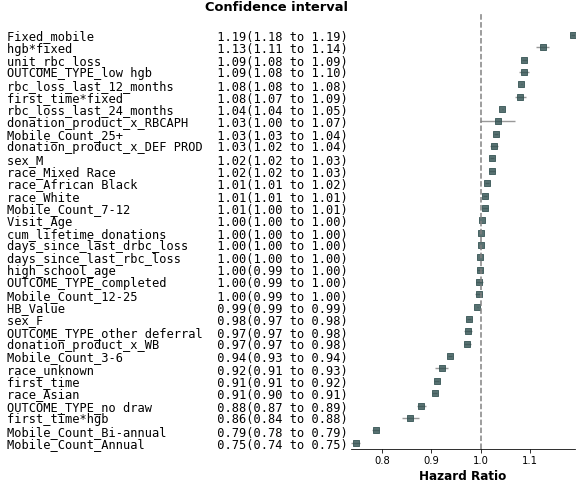

In [52]:
from forestplot import forestplot
# Extract the coefficients and their confidence intervals

ci = cph.confidence_intervals_#.iloc[[2, 21, 22, 5, 4, 6, 23, 10, 16, 17, 14, 13, 11, 25, 19, 9, 8, 24, 18, 15, 20, 1],:]

coef = cph.hazard_ratios_
""""[['Fixed_mobile', 'OUTCOME_TYPE_no draw', "OUTCOME_TYPE_other deferral",
                           'rbc_loss_last_12_months','unit_rbc_loss','rbc_loss_last_24_months', 
                           'first_time*fixed',  'sex_M','race_Mixed Race',  'race_White', 
                           'race_African Black', 'donation_product_x_WB', 'donation_product_x_DEF PROD',
                           'hgb*fixed', 'OUTCOME_TYPE_completed', 'sex_F', 'high_school_age','first_time*hgb',
                           'race_unknown','race_Asian', 'OUTCOME_TYPE_low hgb', 'first_time']]"""

covariate=coef.index
"""['Fixed site (vs Mobile)', 'Outcome: No draw', 'Non-hemoglobin deferral',
             'RBC lost in past 12 months','Units of RBC lost',  'RBC lost in the last 24 months', 
            'First time donors at a fixed site (interaction term)', 'Male', 'Mixed race','Race: White',
         'Race: Black', 'Whole Blood Donation Product', 'Any Deferral', 'Hemoglobin Deferral at a Fixed Site (Interaction Term)',
         'Completed Donation', 'Female', "Age Group: <20, High School",'First Time Donors with HGB Deferral (Interaction Term)', 'Unknown race', 'Race: Asian', 'Hemoglobin Deferral', 'First Time Donors']"""

# Create a dataframe to store the coefficients and their confidence intervals
data = pd.DataFrame({'covariate': covariate, 'coef': coef, 'lower': ci['95% lower-bound'], 'upper': ci['95% upper-bound']})

data['lower'] = np.exp(data['lower'])
data['upper'] = np.exp(data['upper'])

# Sort the dataframe in descending order of coefficients
data = data.sort_values('coef', ascending=False)

# Create a numpy array of indices for each covariate
ind = np.arange(data.shape[0])


fp=forestplot(data,  # the dataframe with results data
              estimate="coef",  # col containing estimated effect size 
              ll="lower", hl="upper",  # columns containing conf. int. lower and higher limits
              varlabel="covariate",  # column containing variable label
              ylabel="Confidence interval",  # y-label title
              xlabel="Hazard Ratio",  # x-label title
             )
fp.axvline(x=1.00, linestyle='--', color='gray')
plt.show()